# Requirements

In [1]:

#pip install opencv-python


# Imports

In [9]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io


# Reasearch


**Can OpenCV detect everything? Or, Do I need to prepare my own pretrained model?**

> OpenCV's pre-trained Haar Cascade classifiers: **face, eye, smile, full body, pedestrian, silverware, licence plate detection**

>  https://github.com/opencv/opencv

**What pre-trained models are available?**

- pretrained YOLO model for object detection

> https://pjreddie.com/darknet/yolo/

- pretrained ImageNet models in TensorFlow and Keras

- pretrained model from Caffe Framework

- pretrained SSD model (Single shot multibox detector)

> https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

> models pretrianed on the COCO 2017 Dataset: CenterNet HourGlass104, CenterNet Resnet50, CenterNet MobileNetV2, Efficient Det, SSD MobileNet, SSD ResNet, Faster R-CNN ResNet, Mask R-CNN ResNet, ExtremeNet

- PyTorch


# ObjectDetector

In [27]:

class ObjectDetector:
    pass


# OpenCV library

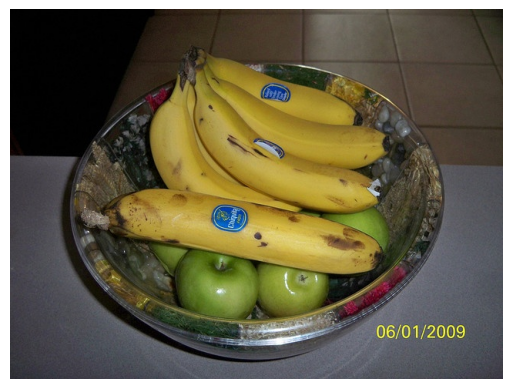

In [17]:

original = cv2.imread("data/train_image_458756.jpg")
original = cv2.cvtColor(original, cv2.COLOR_RGB2BGR)

plt.imshow(original)
plt.axis('off')
plt.show()


In [18]:

image = original.copy()
x, y, w, h = 0, 0, 0, 0

# cvtColor() and threshold()
# To convert the given image into binary
# The cvtColor() function is used to convert one color space into another, and we will use it to convert the BGR image to grayscale.
# The threshold() function converts the grayscale image into binary with only two values, 0 and 255.

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# findContours()
# We can find the contours of the given image
# we have to use a binary or black and white image

ROI_number = 0

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# boundingRect()
# We can find and add a bounding rectangle or box around shapes present in an image
# returns the x and y coordinates along with the rectangle’s width and height, 
# We must pass the contours inside

# rectangle()
# and we can use these values to draw a rectangle around the shape present in the image

bounding_boxes = []

for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    #print(x, y, w, h)
    
    #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
    bounding_boxes.append([x, y, w, h])


In [19]:

# TODO: There are many bounding boxes and the result does not look relevant. Find different solution.

print(f"Length {len(bounding_boxes)}")
bounding_boxes[:5]


Length 690


[[565, 479, 1, 1],
 [563, 479, 1, 1],
 [552, 479, 2, 1],
 [548, 479, 1, 1],
 [542, 479, 1, 1]]

# Yolo v3

In [4]:

image_id = '458756'
coco_classes = []

# Load YOLO
net = cv2.dnn.readNet("data/yolov3.weights", "data/yolov3.cfg")

# Load COCO class labels
with open("data/coco.names", "r") as f:
    coco_classes = [line.strip() for line in f]

# Load image
image = cv2.imread(f"data/train_image_{image_id}.jpg");height, width, _ = image.shape

print(height, width, _)


480 640 3


In [6]:

# Convert image to blob format
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)


In [7]:

# This method is used to get the names of the unconnected output layers of the neural network
output_layers = net.getUnconnectedOutLayersNames()

# Run forward pass
outs = net.forward(output_layers)


In [10]:

# Information to display
class_ids = []
confidences = []
boxes = []

# Loop over each detection
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > 0.5:  # Adjust confidence threshold as needed
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
            

In [13]:

# Apply non-maximum suppression to remove overlapping boxes
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)


In [14]:

# Draw bounding boxes on the image
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = f"{coco_classes[class_ids[i]]}: {confidences[i]:.2f}"
        color = (0, 255, 0)  # Green color for the bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        

In [15]:

# Save image
image_name = f"detected_image_{image_id}.jpg"
cv2.imwrite(f"data/{image_name}", image)


True

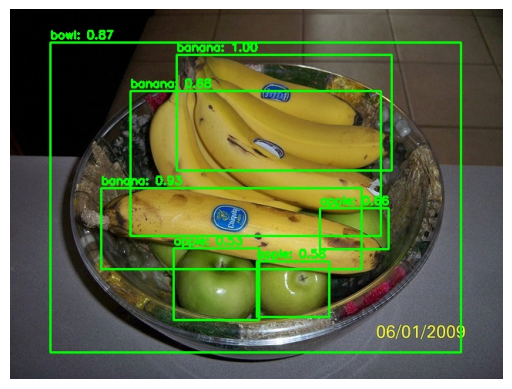

In [16]:

# load image with detected objects
image = cv2.imread("data/detected_image_458756.jpg")
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

plt.imshow(image)
plt.axis('off')
plt.show()
